# The Habitual Action Network

Habitual network

Assuming generative model is perfect, then action selected would always be the action that maximises chance of observing prior preferences. Hence habitual network can be trained to output maximally rewarding actions, as these actions are the free energy minimising actions.

Also has a nice interpretation as long as the generative models keep training. Eventually the generative model is less sure about old things. Why people eventually revisit old states they were previously certain about.

As far as an agent knows, if observations are confirming perfectly to expectations then it has a perfect world model. So why would it change it? It’s only when an uncertain observation comes in that the agent needs to reconsider whether or not it has the best model of the world.


I think this network should be performing policy gradient method but instead of minimising the discounted reward sequence it should minimise the discounted external EFE/FEEF component sequence. That way in the end the end the fast and slow thinking methods should be converging as the world model continues to improve


What is this network trying to learn?
- This network is trying to learn the state action mapping that maximises the probability of being in the preferred states
- It is also trying to learn to output actions that maximise the extrinsic part of the EFE/FEEF


What does this network take as input?
- Current state
- Maybe sequence of previous states and actions

What should this network output?
- The action that leads to the next state that maximally achieves the prior preferences

How should this network learn?
- It should learn by outputting



In [1]:
from util import random_observation_sequence, transform_observations
import matplotlib.pyplot as plt
import gym

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

In [3]:
gamma = np.ones(5)*0.99
rewards = np.array([-1,-1,-1,-1, 1]).reshape((5,1))
gamma_t = np.power(gamma, np.arange(rewards.shape[0]))
gamma_t

array([1.        , 0.99      , 0.9801    , 0.970299  , 0.96059601])

In [4]:
env = gym.make('MountainCarContinuous-v0')
env.action_space.seed(42)

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

all_observations = []
all_observations_scaled = []
actions = []
rewards = []
num_episodes = 1

# obs_stddev = [0.05, 0.05]
obs_stddev = [0, 0]

t_max = 200

for i in range(num_episodes):
    o, a, r = random_observation_sequence(env, t_max, epsilon=0.1)
    # o_scaled = transform_observations(o, observation_max, observation_min, [0.05, 0.05])
    # o_scaled = transform_observations(o, observation_max, observation_min, obs_stddev)
    o_scaled = o
    actions.append(a)

    rewards.append(r)

    # o = transform_observations(o, observation_max, observation_min, [0, 0])

    all_observations_scaled.append(o_scaled)
    all_observations.append(o[:-1])

all_observations = np.vstack(all_observations)
all_observations_scaled = np.vstack(all_observations_scaled)
actions = np.vstack(actions)
rewards = np.vstack(rewards).T
# rewards = rewards.reshape(rewards.shape[0])
print(all_observations.shape, actions.shape, rewards.shape)

(200, 2) (200, 1) (200, 1)


In [5]:
all_observations

array([[-5.80922246e-01,  0.00000000e+00],
       [-5.80871999e-01,  5.02401053e-05],
       [-5.80771863e-01,  1.00109006e-04],
       [-5.80622613e-01,  1.49237923e-04],
       [-5.80425322e-01,  1.97263857e-04],
       [-5.80181479e-01,  2.43831630e-04],
       [-5.79562306e-01,  6.19182480e-04],
       [-5.78572333e-01,  9.89955617e-04],
       [-5.77218950e-01,  1.35340646e-03],
       [-5.75512111e-01,  1.70684129e-03],
       [-5.73464453e-01,  2.04763492e-03],
       [-5.71091175e-01,  2.37324974e-03],
       [-5.68409920e-01,  2.68125441e-03],
       [-5.65440595e-01,  2.96934228e-03],
       [-5.62205255e-01,  3.23534803e-03],
       [-5.57418704e-01,  4.78656217e-03],
       [-5.51116586e-01,  6.30208896e-03],
       [-5.43346047e-01,  7.77055090e-03],
       [-5.34165144e-01,  9.18088108e-03],
       [-5.23642719e-01,  1.05224280e-02],
       [-5.11857629e-01,  1.17850704e-02],
       [-4.98898298e-01,  1.29593424e-02],
       [-4.84861732e-01,  1.40365707e-02],
       [-4.

In [6]:
act_net = HabitualAction(2, 1, 10, [100])

act_net.compile(optimizer=tf.keras.optimizers.Adam())

act_net.habit_action_model.summary()

NameError: name 'HabitualAction' is not defined

In [ ]:
# act_net.fit(all_observations, (actions, cum_rewards), batch_size=all_observations.shape[0], epochs=100)

# act_net.train_on_batch(all_observations, (actions, cum_rewards))

## How about multiple runs?

In [7]:
act_net = HabitualAction(2, 1, 10, [20, 20])

act_net.compile(optimizer=tf.keras.optimizers.Adam())

act_net.habit_action_model.summary()

NameError: name 'HabitualAction' is not defined

In [8]:
t_max = 1000
num_episodes = 250

for i in range(num_episodes):

    all_observations = []
    actions = []
    rewards = []

    o, a, r = random_observation_sequence(env, t_max, epsilon=0.1)
    # o_scaled = transform_observations(o, observation_max, observation_min, [0.05, 0.05])
    o = transform_observations(o, observation_max, observation_min, obs_stddev)
    actions.append(a)
    rewards.append(r)

    all_observations.append(o[:-1])

    all_observations = np.vstack(all_observations)
    all_observations_scaled = np.vstack(all_observations_scaled)
    actions = np.vstack(actions)
    rewards = np.vstack(rewards).T
    # rewards = rewards.reshape(rewards.shape[1])

    # print(all_observations.shape, actions.shape, rewards.shape)

    cum_rewards = compute_discounted_cumulative_reward(rewards, 0.99)
    # cum_rewards

    cum_rewards = cum_rewards

    # print(cum_rewards.shape[0])
    loss = act_net.train_on_batch(all_observations, (actions, cum_rewards))
    print(loss)

NameError: name 'compute_discounted_cumulative_reward' is not defined

In [9]:
act_net(all_observations)

NameError: name 'act_net' is not defined

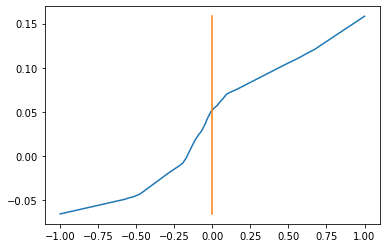

In [12]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T
actions_pred = act_net(obs_pos)

actions_pred


plt.plot(obs_pos, actions_pred)

tf.Tensor(
[[-0.31013045]
 [-0.304491  ]
 [-0.29876006]
 [-0.29300746]
 [-0.28723356]
 [-0.2814387 ]
 [-0.2756233 ]
 [-0.26978764]
 [-0.26393202]
 [-0.25805688]
 [-0.25216267]
 [-0.24624962]
 [-0.24031821]
 [-0.2343688 ]
 [-0.22840181]
 [-0.22241755]
 [-0.21641651]
 [-0.2103991 ]
 [-0.20436564]
 [-0.1983167 ]
 [-0.19225259]
 [-0.18617374]
 [-0.18008061]
 [-0.17397363]
 [-0.16738912]
 [-0.16059497]
 [-0.15378556]
 [-0.14696153]
 [-0.14012344]
 [-0.133272  ]
 [-0.12640776]
 [-0.11953144]
 [-0.11264361]
 [-0.10574493]
 [-0.09883604]
 [-0.09191763]
 [-0.08499034]
 [-0.07805482]
 [-0.07111175]
 [-0.06416176]
 [-0.05690729]
 [-0.04948502]
 [-0.04320386]
 [-0.03603539]
 [-0.0242275 ]
 [-0.00848999]
 [ 0.00681748]
 [ 0.02055343]
 [ 0.03384443]
 [ 0.04626157]
 [ 0.05806721]
 [ 0.0694987 ]
 [ 0.07780202]
 [ 0.08919108]
 [ 0.10048411]
 [ 0.11039207]
 [ 0.1189672 ]
 [ 0.1270141 ]
 [ 0.13225175]
 [ 0.13751256]
 [ 0.14276569]
 [ 0.14801072]
 [ 0.15324745]
 [ 0.1584756 ]
 [ 0.16369487]
 [ 0.16890499]

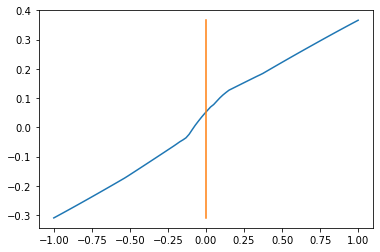

In [13]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T
actions_pred = act_net(vel_pos)
print(actions_pred)

plt.plot(obs_pos, actions_pred)

## Can it solve the environment?

In [14]:
num_episodes = 10

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

# obs_stddev = [0.05, 0.05]
obs_stddev = [0, 0]


t_max = 1000

for i in range(num_episodes):

    env = gym.make('MountainCarContinuous-v0')

    obs = env.reset()

    done = False
    rewards = []

    t = 0
    while not done:

        env.render()

        obs = obs.reshape(1, obs.shape[0])
        obs = transform_observations(obs, observation_max, observation_min, obs_stddev)

        # print(obs)

        action = act_net(obs)
        action = action.numpy()

        obs, reward, done, info = env.step(action)

        # print(obs)

        rewards.append(reward)

        t += 1

        if t == t_max:
            done = True

    print(t)
    if t < t_max:
        print("success")
    else:
        print("Failure")
        print("max obs", obs)

    print(np.sum(rewards))
    # print(rewards)




env.close()

490
success
99.14761416596713



KeyboardInterrupt



In [13]:
n = 50
both = [[i/n, j/n] for i in range(-1*n, n) for j in range(-1*n, n)]
both = np.array(both)
both

both_acts = act_net(both)

both_acts

<tf.Tensor: shape=(10000, 1), dtype=float32, numpy=
array([[-0.409816  ],
       [-0.4060031 ],
       [-0.40266117],
       ...,
       [ 0.5045513 ],
       [ 0.50988096],
       [ 0.5151719 ]], dtype=float32)>

In [115]:
n = 50
coords = [[i/n, j/n] for i in range(-1*n, n) for j in range(-1*n, n)]
coords = np.array(coords)
coords


array([[-1.  , -1.  ],
       [-1.  , -0.98],
       [-1.  , -0.96],
       ...,
       [ 0.98,  0.94],
       [ 0.98,  0.96],
       [ 0.98,  0.98]])

In [101]:
x = np.arange(-5, 5.1, 0.5)
y = np.arange(-5, 5.1, 0.5)
X,Y = np.meshgrid(x,y)

X

array([[-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
         0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ],
       [-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
         0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ],
       [-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
         0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ],
       [-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
         0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ],
       [-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
         0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ],
       [-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
         0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ],
       [-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
         0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ],